## Telemetry Analysis

In [1]:
import sys
import os

sys.path.append("../")
os.chdir("../")

In [2]:
import json
from mirrorbench.io.paths import Paths
from mirrorbench.core.run_db.sqlite import SQLiteRunDatabase

In [3]:
run_name = "latency-analysis"
paths = Paths.default()

In [4]:
run_db = SQLiteRunDatabase(
    paths.run_db_path(run_name), run_name
)
run_db.initialize()

In [5]:
episode_rows = run_db._connection().execute(
    "SELECT * FROM episodes WHERE run_id = ?",
    (run_db.run_id,),
).fetchall()
episodes = [dict(row) for row in episode_rows]

In [6]:
datasets = {
    "chatbot_arena_mirror",
    "clariq_mirror",
    "oasst1_mirror",
    "qulac_mirror",
}

In [7]:
def get_dataset_from_episode(episode):
    for dataset in datasets:
        if dataset in episode["unit_id"]:
            return dataset
    raise ValueError(f"Unknown dataset in episode {episode['unit_id']}")


def read_episode_artifact(episode, paths: Paths):
    artifact_path = episode["artifact_path"]
    if artifact_path is None:
        return None
    with open(os.path.join(str(paths.run_dir(run_name)), artifact_path), "r") as f:
        data = json.loads(f.read())
    return data


def get_non_cached_user_assistant_telemetry(artifact, role_type: str):
    assert role_type in {"user_proxy", "assistant_proxy"}
    telemetry = {
        "tokens_input": 0,
        "tokens_output": 0,
        "total_response_time": 0.0,
    }
    for tel in artifact['telemetry']:
        meta = tel['metadata']
        if meta is None:
            print("Warning: telemetry metadata is None")
            continue
        if not meta['cache_hit'] and meta['component'] == role_type:
            for k in telemetry:
                telemetry[k] += tel[k]
    is_valid = telemetry["tokens_input"] > 0 and telemetry["tokens_output"] > 0
    return telemetry, is_valid


def get_judge_telemetry(artifact):
    telemetry = {
        "tokens_input": 0,
        "tokens_output": 0,
        "total_response_time": 0.0,
    }
    for jv in artifact['judge_verdicts']:
        tel = jv['telemetry']
        if tel is None:
            print("Warning: judge verdict telemetry is None")
            continue
        meta = tel['metadata']
        if meta is None:
            print("Warning: telemetry metadata is None")
            continue
        if meta['component'] == 'judge':
            for k in telemetry:
                telemetry[k] += tel[k]
    is_valid = telemetry["tokens_input"] > 0 and telemetry["tokens_output"] > 0
    return telemetry, is_valid


def aggregate_telemetry_per_episode(artifact):
    user_telemetry, is_val_u = get_non_cached_user_assistant_telemetry(artifact, "user_proxy")
    assistant_telemetry, is_val_a = get_non_cached_user_assistant_telemetry(artifact, "assistant_proxy")
    judge_telemetry, is_val_j = get_judge_telemetry(artifact)
    return {
        "user_proxy": user_telemetry,
        "assistant_proxy": assistant_telemetry,
        "judge": judge_telemetry,
        "num_valid_user": int(is_val_u),
        "num_valid_assistant": int(is_val_a),
        "num_valid_judge": int(is_val_j)
    }


def aggregate_uniform_telemetry(tel_a, tel_b):
    assert tel_a.keys() == tel_b.keys()
    assert set(tel_a.keys()) == {"tokens_input", "tokens_output", "total_response_time"}
    return {
        "tokens_input": tel_a["tokens_input"] + tel_b["tokens_input"],
        "tokens_output": tel_a["tokens_output"] + tel_b["tokens_output"],
        "total_response_time": tel_a["total_response_time"] + tel_b["total_response_time"],
    }


def gather_all_episodes_telemetry(episodes, paths: Paths):
    dataset_telemetry = {}
    skipped_episodes = 0
    for episode in episodes:
        dataset = get_dataset_from_episode(episode)
        artifact = read_episode_artifact(episode, paths)
        if artifact is None:
            skipped_episodes += 1
            continue
        episode_telemetry = aggregate_telemetry_per_episode(artifact)
        if dataset not in dataset_telemetry:
            dataset_telemetry[dataset] = {
                "user_proxy": {
                    "tokens_input": 0,
                    "tokens_output": 0,
                    "total_response_time": 0.0,
                },
                "assistant_proxy": {
                    "tokens_input": 0,
                    "tokens_output": 0,
                    "total_response_time": 0.0,
                },
                "judge": {
                    "tokens_input": 0,
                    "tokens_output": 0,
                    "total_response_time": 0.0,
                },
                "num_valid_user": 0,
                "num_valid_assistant": 0,
                "num_valid_judge": 0,
            }
        for role in episode_telemetry:
            if role.startswith("num_valid_"):
                dataset_telemetry[dataset][role] += episode_telemetry[role]
            else:
                dataset_telemetry[dataset][role] = aggregate_uniform_telemetry(
                    dataset_telemetry[dataset][role],
                    episode_telemetry[role],
                )
    dataset_telemetry["skipped_episodes"] = skipped_episodes
    dataset_telemetry["total_episodes"] = len(episodes)
    return dataset_telemetry


def compute_per_episode_telemetry(dataset_to_telemetry):
    dataset_to_per_x_telemetry = {}
    umap = {
        "user_proxy": "num_valid_user",
        "assistant_proxy": "num_valid_assistant",
        "judge": "num_valid_judge",
    }
    for dataset, telemetry in dataset_to_telemetry.items():
        if dataset in {"skipped_episodes", "total_episodes"}:
            continue
        dataset_to_per_x_telemetry[dataset] = {}
        for role in ["user_proxy", "assistant_proxy", "judge"]:
            num_valid = telemetry[umap[role]]
            if num_valid == 0:
                dataset_to_per_x_telemetry[dataset][role] = {
                    "tokens_input": 0.0,
                    "tokens_output": 0.0,
                    "total_response_time": 0.0,
                }
            else:
                dataset_to_per_x_telemetry[dataset][role] = {
                    "tokens_input": telemetry[role]["tokens_input"] / num_valid,
                    "tokens_output": telemetry[role]["tokens_output"] / num_valid,
                    "total_response_time": telemetry[role]["total_response_time"] / num_valid,
                }
    return dataset_to_per_x_telemetry

In [8]:
episodes[0]

{'run_id': 'latency-analysis',
 'unit_id': 'proxy:langchain/claude|dataset:jsonl/chatbot_arena_mirror|metric:judge/gteval|0',
 'episode_id': '486ffaca4a834c8b90ec8d689b20b246::dolly-v2-12b',
 'status': 'completed',
 'duration_s': 3.248218499997165,
 'artifact_path': 'artifacts/proxy:langchain/claude|dataset:jsonl/chatbot_arena_mirror|metric:judge/gteval|0/486ffaca4a834c8b90ec8d689b20b246::dolly-v2-12b.json',
 'summary': None,
 'metric_values': '{"metric:judge/gteval": {"metric_name": "metric:judge/gteval", "values": [0.3], "metadata": {"rubric_version": "1.0", "judge_client": "client:langchain/chat", "prompt_version": "1.0", "proxy_user_turn_count": 1, "real_user_turn_count": 1, "scores": [0.3], "reasonings": ["The real user\'s question is concise and direct, using casual language with a straightforward approach. The proxy user\'s question is significantly more formal, verbose, and structured, asking for specific examples and using more sophisticated phrasing like \'specific features o

In [9]:
with open(os.path.join(paths.run_dir(run_name), "artifacts/proxy:langchain/claude|dataset:jsonl/chatbot_arena_mirror|metric:judge/gteval|0/486ffaca4a834c8b90ec8d689b20b246::dolly-v2-12b.json"), "r") as f:
    data = json.loads(f.read())

print(json.dumps(data, indent=4))

{
    "spec": {
        "episode_id": "486ffaca4a834c8b90ec8d689b20b246::dolly-v2-12b",
        "task_tag": "chat_arena",
        "chat_history": [
            {
                "role": "user",
                "content": "How do you compare yourself with the other LLM, what makes you different from others and unique?",
                "message_id": "52bef5f1-e4f6-4748-adad-d03f3d3d25fd",
                "name": null,
                "timestamp": null,
                "metadata": {
                    "turn_index": 0
                }
            },
            {
                "role": "assistant",
                "content": "I'm hard-working, dedicated and passionate about what I do. I always put in honest effort in whatever I do and that shows in my results. My goal is to always do better and better. I want to inspire others with my stories of success.",
                "message_id": "b7a4bf0f-0628-4db3-8e10-6da8fc11965d",
                "name": null,
                "timestamp": nu

In [10]:
dataset_to_telemetry = gather_all_episodes_telemetry(episodes, paths)

In [11]:
dataset_to_telemetry['qulac_mirror']['assistant_proxy'] = {
    "tokens_input": int((276866 * 40740) / 160178),
    "tokens_output": int((73713 * 5219) / 8304),
    "total_response_time": float((697.2703059550986 * 222.65571970197198) / 267.7768702929461),
}
dataset_to_telemetry['qulac_mirror']['num_valid_assistant'] = 200

In [12]:
dataset_to_telemetry

{'chatbot_arena_mirror': {'user_proxy': {'tokens_input': 160178,
   'tokens_output': 8304,
   'total_response_time': 267.7768702929461},
  'assistant_proxy': {'tokens_input': 276866,
   'tokens_output': 73713,
   'total_response_time': 697.2703059550986},
  'judge': {'tokens_input': 3727747,
   'tokens_output': 262212,
   'total_response_time': 10554.37324329483},
  'num_valid_user': 194,
  'num_valid_assistant': 194,
  'num_valid_judge': 581},
 'clariq_mirror': {'user_proxy': {'tokens_input': 483231,
   'tokens_output': 20747,
   'total_response_time': 693.2015806300333},
  'assistant_proxy': {'tokens_input': 366373,
   'tokens_output': 156069,
   'total_response_time': 1547.1621056499425},
  'judge': {'tokens_input': 4476377,
   'tokens_output': 287484,
   'total_response_time': 11359.905086094572},
  'num_valid_user': 200,
  'num_valid_assistant': 200,
  'num_valid_judge': 600},
 'oasst1_mirror': {'user_proxy': {'tokens_input': 147903,
   'tokens_output': 15171,
   'total_response_t

In [13]:
per_episode_telemetry = compute_per_episode_telemetry(dataset_to_telemetry)

In [14]:
per_episode_telemetry

{'chatbot_arena_mirror': {'user_proxy': {'tokens_input': 825.659793814433,
   'tokens_output': 42.8041237113402,
   'total_response_time': 1.3802931458399283},
  'assistant_proxy': {'tokens_input': 1427.1443298969073,
   'tokens_output': 379.9639175257732,
   'total_response_time': 3.5941768348200958},
  'judge': {'tokens_input': 6416.08777969019,
   'tokens_output': 451.3115318416523,
   'total_response_time': 18.16587477331296}},
 'clariq_mirror': {'user_proxy': {'tokens_input': 2416.155,
   'tokens_output': 103.735,
   'total_response_time': 3.4660079031501665},
  'assistant_proxy': {'tokens_input': 1831.865,
   'tokens_output': 780.345,
   'total_response_time': 7.735810528249712},
  'judge': {'tokens_input': 7460.628333333333,
   'tokens_output': 479.14,
   'total_response_time': 18.933175143490953}},
 'oasst1_mirror': {'user_proxy': {'tokens_input': 746.9848484848485,
   'tokens_output': 76.62121212121212,
   'total_response_time': 2.091085540353864},
  'assistant_proxy': {'token

Figure saved as 'telemetry_analysis.pdf'


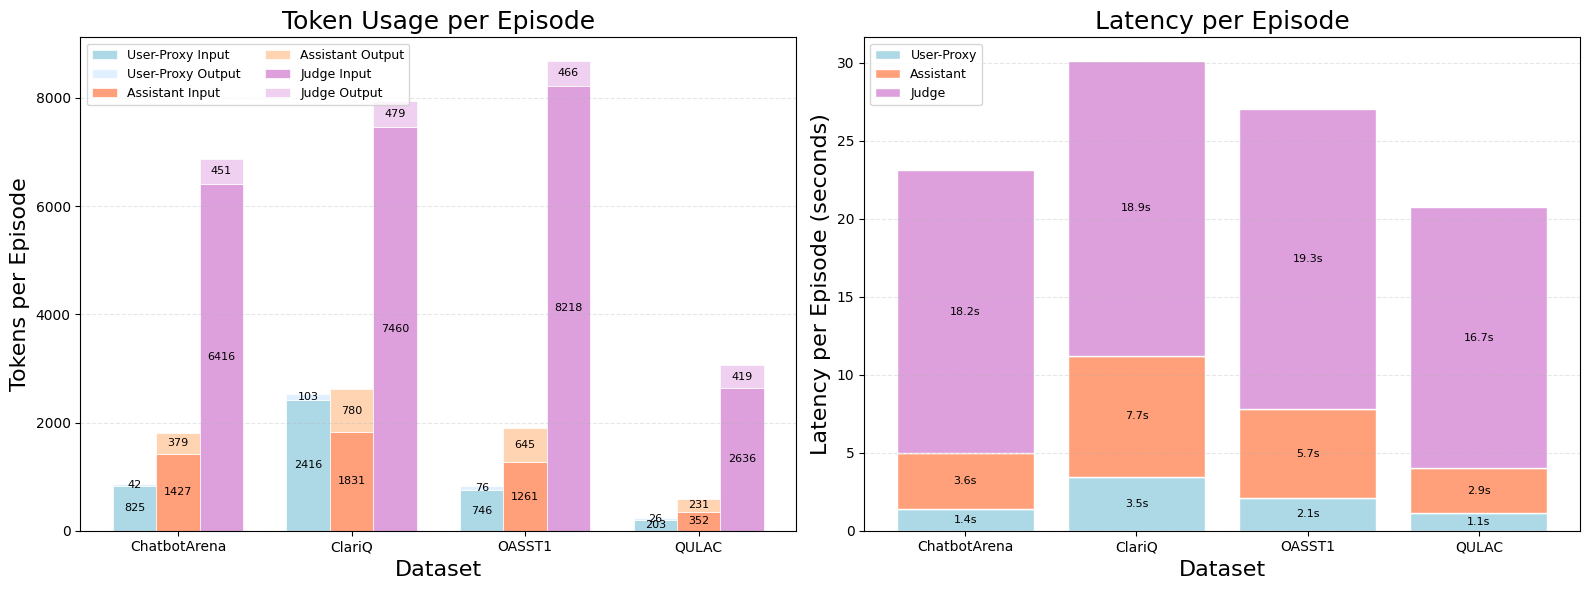

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
datasets = ['chatbot_arena_mirror', 'clariq_mirror', 'oasst1_mirror', 'qulac_mirror']
dataset_labels = ['ChatbotArena', 'ClariQ', 'OASST1', 'QULAC']
roles = ['user_proxy', 'assistant_proxy', 'judge']
role_labels = ['User-Proxy', 'Assistant', 'Judge']

# Define colors: lighter shades that work well with black text
# Format: (input tokens/latency color, output tokens color)
colors = {
    'user_proxy': ('#ADD8E6', '#E0F0FF'),      # Light blue, Lighter blue
    'assistant_proxy': ('#FFA07A', '#FFD4B3'), # Light salmon, Lighter salmon
    'judge': ('#DDA0DD', '#F0D0F0')            # Plum, Lighter plum
}

# Extract data
token_input_data = {role: [per_episode_telemetry[ds][role]['tokens_input'] for ds in datasets] for role in roles}
token_output_data = {role: [per_episode_telemetry[ds][role]['tokens_output'] for ds in datasets] for role in roles}
latency_data = {role: [per_episode_telemetry[ds][role]['total_response_time'] for ds in datasets] for role in roles}

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ========== Subplot 1: Token Usage (Grouped Stacked Bar Chart) ==========
x = np.arange(len(datasets))
width = 0.25  # Width of each bar

for i, role in enumerate(roles):
    positions = x + i * width
    # Stack input and output tokens
    input_bars = ax1.bar(positions, token_input_data[role], width,
                         label=f'{role_labels[i]} Input',
                         color=colors[role][0], edgecolor='white', linewidth=0.5)
    output_bars = ax1.bar(positions, token_output_data[role], width,
                          bottom=token_input_data[role],
                          label=f'{role_labels[i]} Output',
                          color=colors[role][1], edgecolor='white', linewidth=0.5)

    # Add value labels inside bars - always show all values in black
    for j, (inp, out, pos) in enumerate(zip(token_input_data[role], token_output_data[role], positions)):
        # Label for input tokens (bottom half)
        ax1.text(pos, inp/2, f'{int(inp)}',
                ha='center', va='center', fontsize=8, color='black')
        # Label for output tokens (top half) - always show even if small
        ax1.text(pos, inp + out/2, f'{int(out)}',
                ha='center', va='center', fontsize=8, color='black')

ax1.set_xlabel('Dataset', fontsize=16)
ax1.set_ylabel('Tokens per Episode', fontsize=16)
ax1.set_title('Token Usage per Episode', fontsize=18)
ax1.set_xticks(x + width)
ax1.set_xticklabels(dataset_labels, fontsize=10)
ax1.legend(loc='upper left', fontsize=9, ncol=2)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# ========== Subplot 2: Latency (Stacked Bar Chart) ==========
# Stack: user at bottom, assistant in middle, judge on top
user_latency = [latency_data['user_proxy'][i] for i in range(len(datasets))]
assistant_latency = [latency_data['assistant_proxy'][i] for i in range(len(datasets))]
judge_latency = [latency_data['judge'][i] for i in range(len(datasets))]

bars1 = ax2.bar(dataset_labels, user_latency, color=colors['user_proxy'][0], 
                edgecolor='white', linewidth=1, label='User-Proxy')
bars2 = ax2.bar(dataset_labels, assistant_latency, bottom=user_latency,
                color=colors['assistant_proxy'][0], edgecolor='white', linewidth=1, label='Assistant')
bars3 = ax2.bar(dataset_labels, judge_latency, 
                bottom=[user_latency[i] + assistant_latency[i] for i in range(len(datasets))],
                color=colors['judge'][0], edgecolor='white', linewidth=1, label='Judge')

# Add value labels inside bars - all in black
for i in range(len(datasets)):
    # User latency
    ax2.text(i, user_latency[i]/2, f'{user_latency[i]:.1f}s', 
            ha='center', va='center', fontsize=8, color='black')
    
    # Assistant latency
    ax2.text(i, user_latency[i] + assistant_latency[i]/2, f'{assistant_latency[i]:.1f}s', 
            ha='center', va='center', fontsize=8, color='black')
    
    # Judge latency
    ax2.text(i, user_latency[i] + assistant_latency[i] + judge_latency[i]/2, 
            f'{judge_latency[i]:.1f}s', 
            ha='center', va='center', fontsize=8, color='black')

ax2.set_xlabel('Dataset', fontsize=16)
ax2.set_ylabel('Latency per Episode (seconds)', fontsize=16)
ax2.set_title('Latency per Episode', fontsize=18)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

# Save as PDF
plt.savefig('.cached/one_run_telemetry.pdf', format='pdf', bbox_inches='tight', dpi=300)
print("Figure saved as 'telemetry_analysis.pdf'")

plt.show()